In [1]:
import numpy as np
import pandas as pd
import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
%pip install mlflow dagshub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import dagshub
dagshub.init(repo_owner='Atish019', repo_name='swiggy_delivery_time_prediction', mlflow=True)

Accessing as Atish019

Initialized MLflow to track repo "Atish019/swiggy_delivery_time_prediction"

Repository Atish019/swiggy_delivery_time_prediction initialized!

In [4]:
import mlflow

In [5]:
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/Atish019/swiggy_delivery_time_prediction.mlflow")

In [6]:
# mlflow experiment

mlflow.set_experiment("Exp 4 - LGBM HP Tuning")

2025/06/29 07:07:39 INFO mlflow.tracking.fluent: Experiment with name 'Exp 4 - LGBM HP Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/10bd866786af4787980b9303d12e894f', creation_time=1751161053593, experiment_id='2', last_update_time=1751161053593, lifecycle_stage='active', name='Exp 4 - LGBM HP Tuning', tags={}>

In [7]:
from sklearn import set_config

set_config(transform_output="pandas")

# Load the Data

In [9]:
# load the data

df = pd.read_csv('swiggy.csv')

df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,0x7c09,JAPRES04DEL01,30,4.8,26.902328,75.794257,26.912328,75.804257,24-03-2022,11:35:00,11:45:00,conditions Windy,High,1,Meal,motorcycle,0,No,Metropolitian,(min) 32
45589,0xd641,AGRRES16DEL01,21,4.6,0.000000,0.000000,0.070000,0.070000,16-02-2022,19:55:00,20:10:00,conditions Windy,Jam,0,Buffet,motorcycle,1,No,Metropolitian,(min) 36
45590,0x4f8d,CHENRES08DEL03,30,4.9,13.022394,80.242439,13.052394,80.272439,11-03-2022,23:50:00,00:05:00,conditions Cloudy,Low,1,Drinks,scooter,0,No,Metropolitian,(min) 16
45591,0x5eee,COIMBRES11DEL01,20,4.7,11.001753,76.986241,11.041753,77.026241,07-03-2022,13:35:00,13:40:00,conditions Cloudy,High,0,Snack,motorcycle,1,No,Metropolitian,(min) 26


# Clean Data

In [11]:
data_clean_utils.perform_data_cleaning(df)

In [12]:
# load the cleaned data

df = pd.read_csv('swiggy_cleaned.csv')

df

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_type
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,19,3,saturday,1,15.0,11.0,morning,3.025149,short
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,25,3,friday,0,5.0,19.0,evening,20.183530,very_long
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,19,3,saturday,1,15.0,8.0,morning,1.552758,short
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,JAP,24,3,thursday,0,10.0,11.0,morning,1.489846,short
45498,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,AGR,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,CHEN,11,3,friday,0,15.0,23.0,night,4.657195,short
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,COIMB,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium


In [13]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [14]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45498,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,0,15.0,evening,NaN,NaN
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [15]:
# check for missing values

df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [16]:
# check for duplicates

df.duplicated().sum()

0

<Axes: >

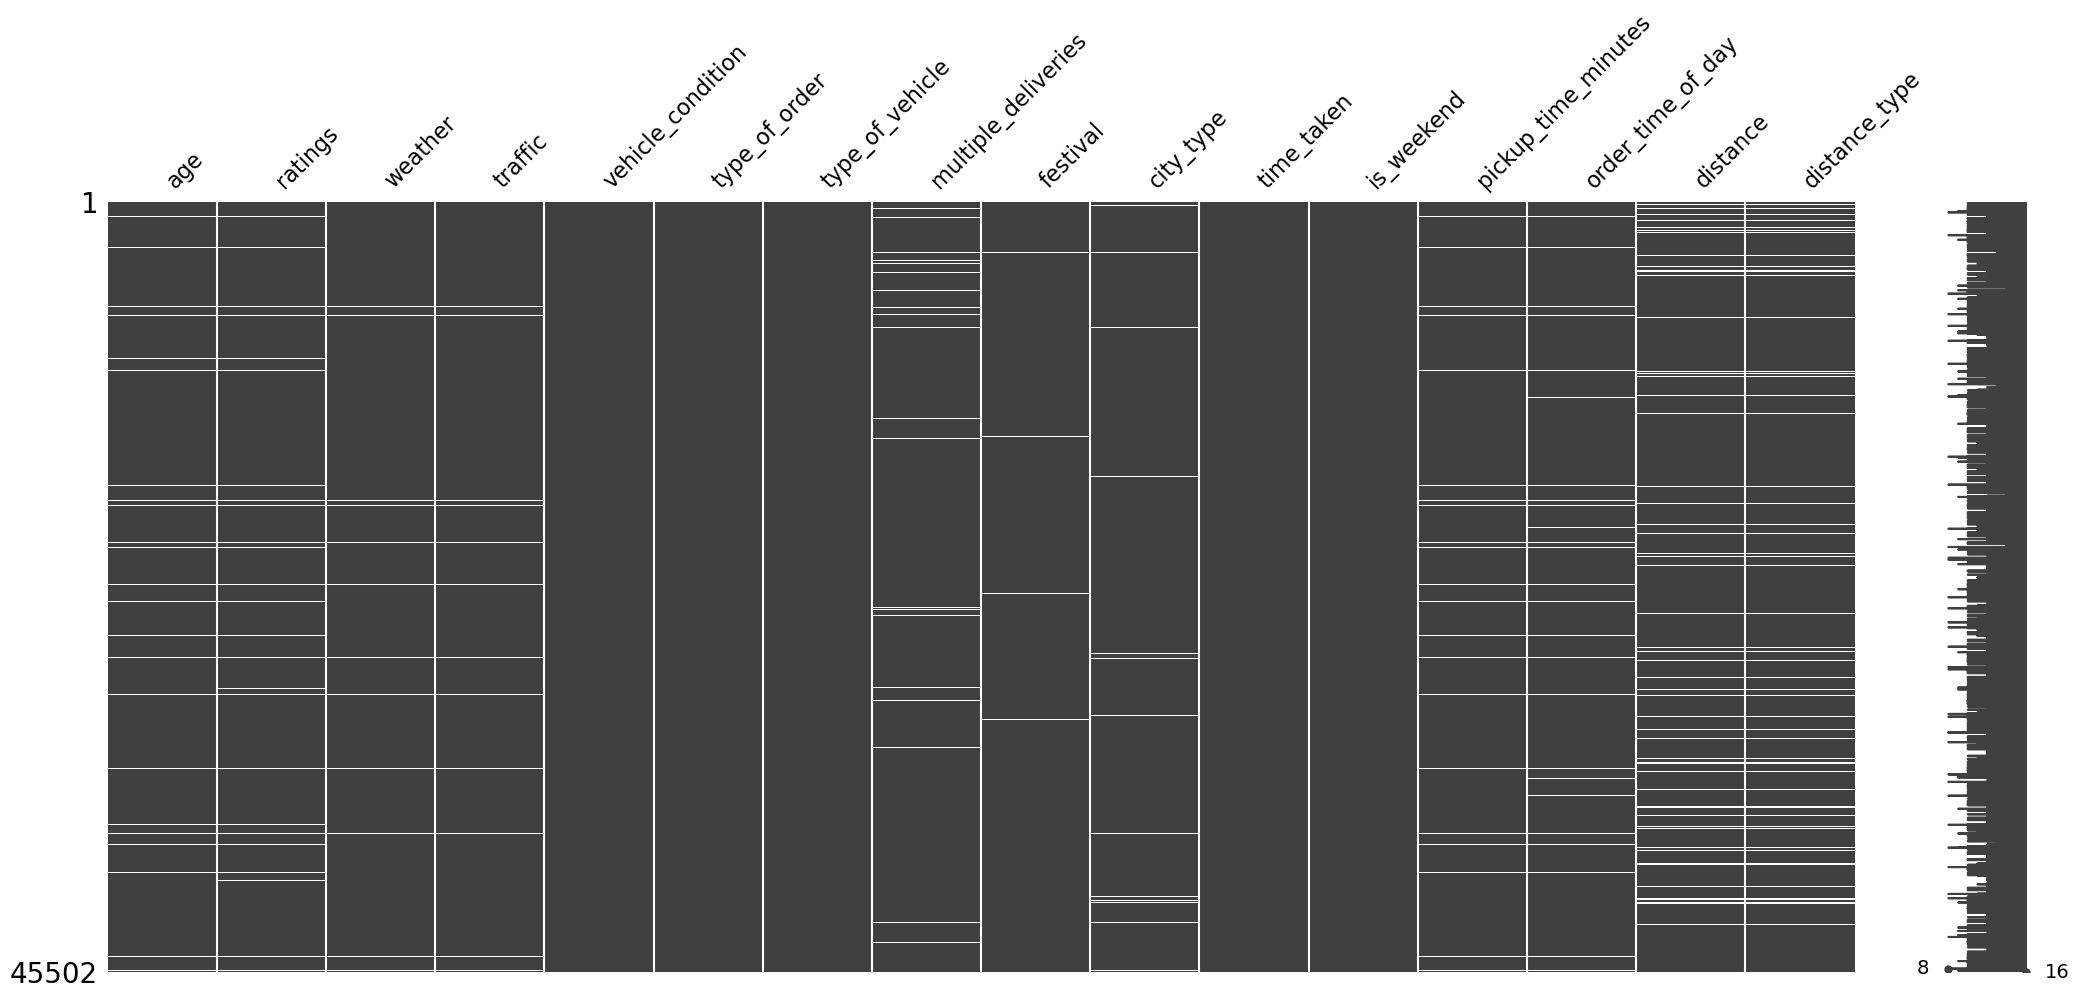

In [17]:
import missingno as msno

msno.matrix(df)

In [18]:
# columns that have missing values

missing_cols = (
                    df
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

# Drop Missing values

In [20]:
temp_df = df.copy().dropna()

In [21]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45496,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,night,16.600272,very_long
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [22]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [24]:
# missing values in train data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [25]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [26]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [27]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


0.0

# Pre-Processing Pipeline

In [29]:
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather',
                    'type_of_order',
                    'type_of_vehicle',
                    "festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [30]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'is_weekend',
 'order_time_of_day']

In [31]:
X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [32]:
# # features to fill values with mode

# features_to_fill_mode = ['multiple_deliveries','festival','city_type']
# features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

# features_to_fill_missing

In [33]:
# # simple imputer to fill categorical vars with mode

# simple_imputer = ColumnTransformer(transformers=[
#     ("mode_imputer",SimpleImputer(strategy="most_frequent",add_indicator=True),features_to_fill_mode),
#     ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing",add_indicator=True),features_to_fill_missing)
# ],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

# simple_imputer

In [34]:
# simple_imputer.fit_transform(X_train)

In [35]:
# simple_imputer.fit_transform(X_train).isna().sum()

In [36]:
# knn imputer

# knn_imputer = KNNImputer(n_neighbors=5)

In [37]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [38]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [39]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium' 'short' 'long' 'very_long']


In [40]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(
        categories=[traffic_order, distance_type_order],
        encoded_missing_value=-999,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ), ordinal_cat_cols)
], remainder="passthrough", n_jobs=1, verbose_feature_names_out=False)

preprocessor

ColumnTransformer(n_jobs=1, remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [41]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                # ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor)
                                # ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=1, remainder='passthrough',
                                   transformers=[('scale', MinMaxScaler(),
                                                  ['age', 'ratings',
                                                   'pickup_time_minutes',
                                                   'distance']),
                                                 ('nominal_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehicle',
                                                   'festival', 'city_type',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False))])

In [42]:
# do data preprocessing

X_train_trans = processing_pipeline.fit_transform(X_train)

X_test_trans = processing_pipeline.transform(X_test)

In [43]:
X_train_trans

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
8708,0.473684,0.56,1.0,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0,2.0
25198,1.000000,0.76,0.0,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
34049,0.473684,0.80,0.5,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1,0.0
25987,1.000000,0.92,1.0,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,1.0
37121,0.526316,0.76,0.5,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20239,0.578947,0.92,0.5,0.451895,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,0,0.0
7590,0.052632,1.00,1.0,0.612270,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1,1.0
13610,0.526316,0.92,0.0,0.322877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0
1045,0.947368,0.96,0.5,0.004486,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0


In [44]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [45]:
from lightgbm import LGBMRegressor
import optuna

In [46]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

In [47]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators",10,200),
            "max_depth": trial.suggest_int("max_depth",1,40),
            "learning_rate": trial.suggest_float("learning_rate",0.1,0.8),
            "subsample": trial.suggest_float("subsample",0.5,1),
            "min_child_weight": trial.suggest_int("min_child_weight",5,20),
            "min_split_gain": trial.suggest_float("min_split_gain",0,10),
            "reg_lambda": trial.suggest_float("reg_lambda",0,100),
            "random_state": 42,
            "n_jobs": -1,
        }

        # log model parameters
        mlflow.log_params(params)

        xgb_reg = LGBMRegressor(**params)
        model = TransformedTargetRegressor(regressor=xgb_reg,transformer=pt)

        # train the model
        model.fit(X_train_trans,y_train)

        # get the predictions
        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)


        # perform cross validation
        cv_score = cross_val_score(model,
                                X_train_trans,
                                y_train,
                                cv=5,
                                scoring="neg_mean_absolute_error",
                                n_jobs=-1)

        # mean score
        mean_score = -(cv_score.mean())
        # log avg cross val error
        mlflow.log_metric("cross_val_error",mean_score)

        return mean_score

In [88]:
# Create optuna study
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    # Optimize the objective function
    study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

    # Log best parameters
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_score", study.best_value)

    # Train model on best parameters
    best_lgbm = LGBMRegressor(**study.best_params)
    best_lgbm.fit(X_train_trans, y_train_pt.values.ravel())

    # Predictions
    y_pred_train = best_lgbm.predict(X_train_trans)
    y_pred_test = best_lgbm.predict(X_test_trans)

    # Inverse transform predictions
    y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1, 1))
    y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

    # Cross validation
    model = TransformedTargetRegressor(regressor=best_lgbm, transformer=pt)
    scores = cross_val_score(
        model, X_train_trans, y_train,
        scoring="neg_mean_absolute_error", cv=5, n_jobs=-1
    )

    # Log performance metrics
    mlflow.log_metric("training_error", mean_absolute_error(y_train, y_pred_train_org))
    mlflow.log_metric("test_error", mean_absolute_error(y_test, y_pred_test_org))
    mlflow.log_metric("training_r2", r2_score(y_train, y_pred_train_org))
    mlflow.log_metric("test_r2", r2_score(y_test, y_pred_test_org))
    mlflow.log_metric("cross_val", -scores.mean())

    # Manually save and log model
    model_path = "best_lgbm_model.pkl"
    joblib.dump(best_lgbm, model_path)
    mlflow.log_artifact(model_path, artifact_path="model")


[I 2025-06-29 07:50:30,064] A new study created in memory with name: no-name-873a7b54-6663-43d2-b833-2178ee873749


  0%|          | 0/50 [00:00<?, ?it/s]

🏃 View run salty-slug-500 at: https://dagshub.com/Atish019/swiggy_delivery_time_prediction.mlflow/#/experiments/2/runs/5499ea8b04d54c41a41c4cb91b989980
🧪 View experiment at: https://dagshub.com/Atish019/swiggy_delivery_time_prediction.mlflow/#/experiments/2
🏃 View run luminous-gnu-810 at: https://dagshub.com/Atish019/swiggy_delivery_time_prediction.mlflow/#/experiments/2/runs/c85309e44cfd4162a8101c664515621f
🧪 View experiment at: https://dagshub.com/Atish019/swiggy_delivery_time_prediction.mlflow/#/experiments/2
🏃 View run aged-wren-106 at: https://dagshub.com/Atish019/swiggy_delivery_time_prediction.mlflow/#/experiments/2/runs/88f17310f8704911bf7ed33b3f99b32e
🧪 View experiment at: https://dagshub.com/Atish019/swiggy_delivery_time_prediction.mlflow/#/experiments/2
[I 2025-06-29 07:51:02,768] Trial 6 finished with value: 3.4310378724730044 and parameters: {'n_estimators': 34, 'max_depth': 15, 'learning_rate': 0.31221297030720085, 'subsample': 0.9789101909732494, 'min_child_weight': 16, 

In [90]:
study.best_params

{'n_estimators': 126,
 'max_depth': 32,
 'learning_rate': 0.15993477023872307,
 'subsample': 0.6856605986492736,
 'min_child_weight': 5,
 'min_split_gain': 0.04873620236032,
 'reg_lambda': 11.69585496098843}

In [92]:
study.best_value

3.128687935435772

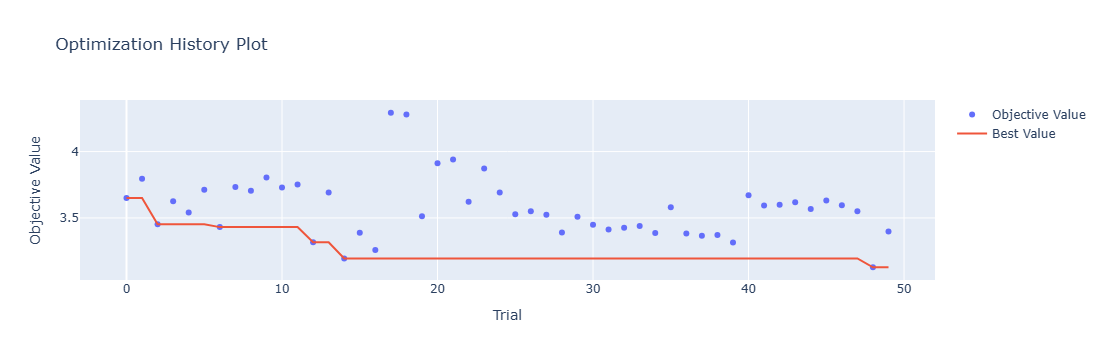

In [94]:
# optimization history plot

optuna.visualization.plot_optimization_history(study)

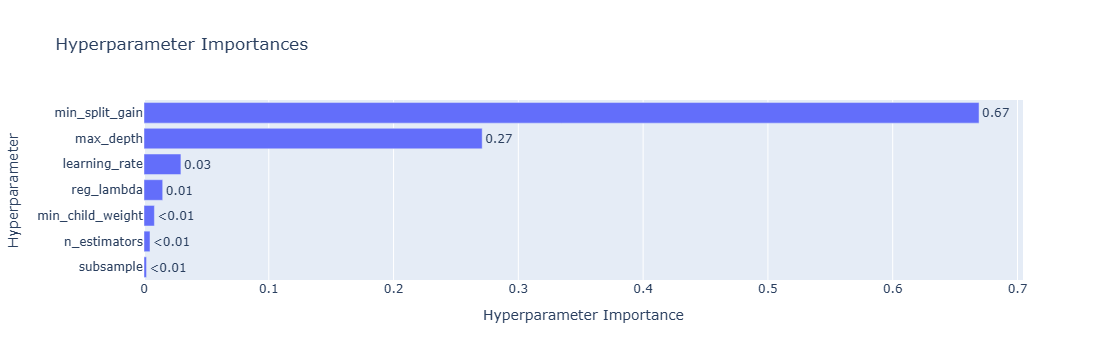

In [96]:
# plot hyperparameter importance plot

optuna.visualization.plot_param_importances(study)

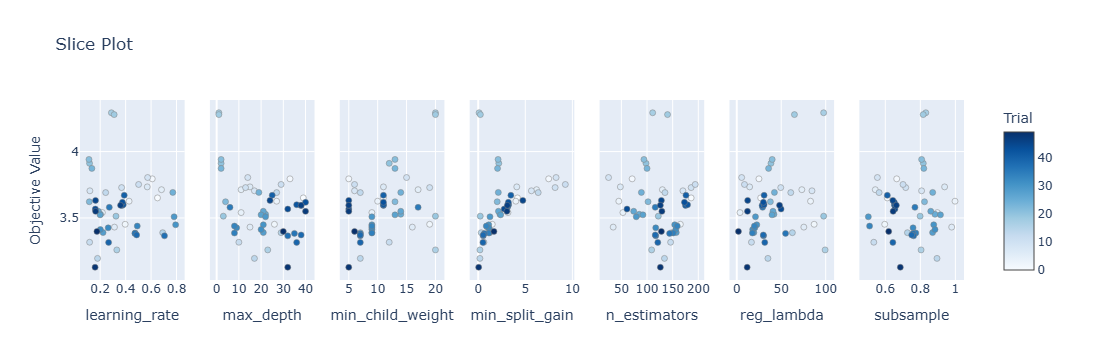

In [97]:
# slice plot

optuna.visualization.plot_slice(study)